<a href="https://colab.research.google.com/github/avkornaev/Python-for-image-processing-course/blob/main/Circular_polarization_part2_Stokes_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary.

The data have NaN values that should be excluded.
The processing algorithm is based on watershed method. If you want to know more, please check the following links: https://imagej.net/plugins/classic-watershed,
https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

#**Install libraries**.

Execute code bellow just once to install the libraries. Then you may comment 'pip' lines using # at the begining of lines of the code.

In [19]:
!pip install -Uqq fastbook
!pip install mat4py

#**Connect to Google disk.**

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import libraries.**

In [21]:
import fastbook
from fastbook import *
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import measure, color, io, img_as_ubyte, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import clear_border, join_segmentations
import pandas as pd
from mat4py import loadmat 
#import tifffile

#**Check the settings.**

In [22]:
#Image under study
dict_path = '/content/drive/MyDrive/Circular_polarisation/1/'
dict_titles = ['Cancer_scan3_sd=60.mat','stokes_norm.mat'] 
download_file = dict_titles[1] # 0 is for Cancer_scan, 1 is for stokes_norm
img_title = 'dop_shift'

#Visualisation
 #Sizes
img_size = [] # empty [] if all the image should be downloaded, or rectangle coordinates, e.g. [0,0,1024,1024]
fig_size = (30,30) # figures size
img_map  = 'Blues' # image map. For example, 'gray','hot','jet','Blues' et al. If you want to know more, please type the following code: help(plt.imshow)
img_map1 = 'jet'
 #Font
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255,255,255)
lineType  = 2

#Filtering
kernel = np.ones((5,5),np.uint8)
kernel4filt = 5
ps = 5 # patch_size
patchDist = 3 # patch_distance
hc = 1.15 # coefficient

numberOfIter = 1 #number of iterations
dist_transf_ratio = 0.1 # distance transform ratio
dist_transf_param = 5
markers_bias = 100

clearBorder = 'off' # delete markers at the borders: 'on' or 'off'

#**Download image.**

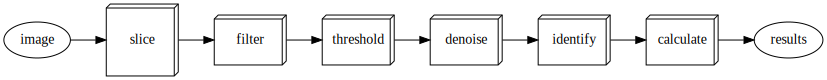

In [23]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=1] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

Download 'mat' file.

In [24]:
dict_img= loadmat(dict_path + download_file)

In [25]:
print('dictionary lenght is', len(dict_img))
dict_img.keys()

dictionary lenght is 1


dict_keys(['stokes_norm'])

In [37]:
dict_list = list(dict_img.keys())
print(dict_list)

['stokes_norm']


Determine additional values.

In [42]:
len(dict_img)

1

In [ ]:
imSize = np.transpose(np.asarray(dict_img[dict_list[0]], dtype=np.float32)).shape
nc = imSize[0]
channels = [0]*nc # images template
j = 0 #auxiliary variable 
print(imSize)

In [28]:
for i in n:
  im = np.transpose(np.asarray(dict_img[dict_list[i]],
                               dtype=np.float32))#read and transpose
  im = np.nan_to_num(im, copy=True, nan=np.nanmedian(im),
                     posinf=None, neginf=None)#replace NANs with median value                             
  im_norm = 255*(im-np.min(im))/(np.max(im)-np.min(im))# normalisation
  im_norm_inv = 255 - im_norm # inverce image
  #imCr = im[img_size[0]:img_size[2],img_size[1]:img_size[3]]#crop, if required
  channels[i]=im_norm_inv

In [41]:
np.shape(im)

(3, 12870439)

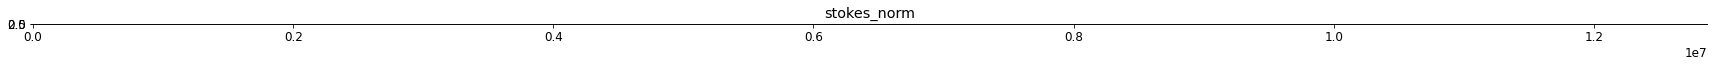

In [29]:
titles = list(dict_img.keys())
plt.figure(figsize=(fig_size[0]*nc,fig_size[0]))
for i in n:
  plt.subplot(nc,1,i+1)
  plt.imshow(channels[i],cmap=img_map1)
  plt.title(titles[i])

**Create templates (empty lists).**

In [30]:
channelsF = [0]*nc # filtered channels template
img_path_temp = [0]*nc # another one template
channelsFGray = [0]*nc # and another one
ret = [0]*nc # one more template
thresh = [0]*nc # one more template
opening = [0]*nc # one more template
sure_bg = [0]*nc # one more template
sure_fg = [0]*nc # one more template
ret1 = [0]*nc # one more template
dist_transform = [0]*nc # one more template
unknown = [0]*nc # one more template
ret2 = [0]*nc # one more template
markers = [0]*nc # one more template
markersi= [0]*nc # one more template
channelsFB = [0]*nc # one more template
channelsFW = [0]*nc # one more template
channelsFWi= [0]*nc # one more template
regions = [0]*nc
numberOfCells = [0]*nc

pixels2microns = 1

#**Filter channel images.**

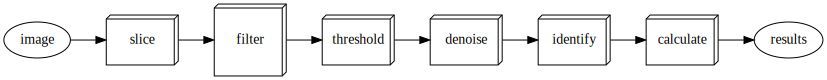

In [31]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=1] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')
# https://laptrinhx.com/five-lessons-from-my-data-science-internship-at-hara-1112784335/

The non-local means denoising and the median filter are performed. 

In [32]:
for i in n:
  # "denoise_nl_means" performs non-local means denoising
  sigma_est = np.mean(estimate_sigma(channels[i], multichannel=False))
  patch_kw = dict(patch_size=ps, patch_distance=patchDist, multichannel=False)
  channelsF[i] = denoise_nl_means(channels[i], h=hc*sigma_est, fast_mode=False, **patch_kw)
  channelsF[i] = np.uint16(channelsF[i])

  # Apply a multidimensional median filter
  channelsF[i] = ndimage.median_filter(channelsF[i], size=kernel4filt)

  print(i,'channel sigma estimation = ',sigma_est)
  print(i,'channel shape: ',channelsF[i].shape, channelsF[i].dtype, type(channelsF[i]))
  print(np.amax(channelsF[i]))

   

0 channel sigma estimation =  3.5814044093511885
0 channel shape:  (3, 12870439) uint16 <class 'numpy.ndarray'>
189


Shifted images.

**Visualize channels after filtering.**

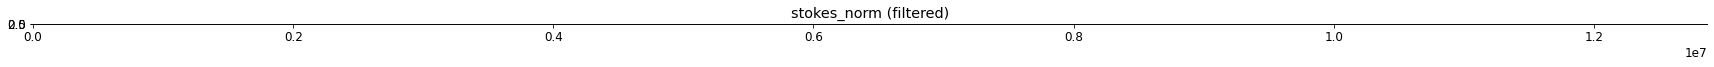

In [33]:
plt.figure(figsize=(fig_size[0]*nc,fig_size[0]))
for i in n:
  plt.subplot(nc,1,i+1)
  plt.imshow(channelsF[i],cmap=img_map1)
  plt.title(titles[i]+' (filtered)')

  # plt.subplot(nc,2,i+2)
  # plt.imshow(channelsF[i],cmap=img_map1)
  # plt.title(titles[i]+' (filtered)')

In [34]:
#plt.figure(figsize=fig_size)
#plt.imshow(channelsF[1],cmap = img_map)

**Create tepmorary 'tiff' files.**

In [35]:
for i in n:
  img_title = dict_list[i]
  img_path_temp[i] = dict_path[0] + img_title + '_' + str(i) + '.tiff' # path 0
  cv2.imwrite(img_path_temp[i], channelsF[i]) # save channels in a temporary tiff file
print(img_path_temp)

['/stokes_norm_0.tiff']


**Read images using OpenCV.**

In [36]:
for i in n:
  channelsFGray[i] = cv2.imread(img_path_temp[i],cv2.IMREAD_GRAYSCALE)
  print(type(channelsFGray[i]),channelsFGray[i].shape,channelsFGray[i].dtype)

error: ignored

#**Threshold and delete noise.**

Threshold image to binary using 'OTSU'. All the thresholded pixels are set to 255. Then remove noise using 'opening' and remove edge touching with 'clear_border' function (optional).

In [ ]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=1] denoise[shape=box3d width=1 height=1] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [ ]:
for i in n:
  ret[i], thresh[i] = cv2.threshold(channelsFGray[i], 0, 255, 
                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  opening[i] = cv2.morphologyEx(thresh[i],cv2.MORPH_OPEN,kernel,
                                iterations = numberOfIter)
  if clearBorder == 'on':
    opening[i] = clear_border(opening[i])

**Identify background and foreground area using OpenCV distance transformation. Apply watershed.**

In [ ]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=1] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

Find sure background and sure foreground regions.

In [ ]:
for i in n:
  sure_bg[i] = cv2.dilate(opening[i],
                          kernel,iterations=numberOfIter) # sure background
  dist_transform[i] = cv2.distanceTransform(opening[i],cv2.DIST_L2,
                                            dist_transf_param)
  
  ret1[i], sure_fg[i] = cv2.threshold(dist_transform[i],
                                      dist_transf_ratio*dist_transform[i].max(),
                                      255,0)
  sure_fg[i] = np.uint8(sure_fg[i]) # sure foreground

Add markers and apply watershed.

In [ ]:
for i in n:
  unknown[i] = cv2.subtract(sure_bg[i], sure_fg[i])
  ret2[i], markers[i] = cv2.connectedComponents(sure_fg[i])
  markers[i] = markers[i] + markers_bias
  markers[i][unknown[i]==255] = 0

  markers[i] = cv2.watershed(cv2.imread(img_path_temp[i]),markers[i]) #The boundary regions will be marked as -1
  channelsFB[i] = cv2.imread(img_path_temp[i])
  channelsFB[i][markers[i] == -1] = [255,0,0] # highlight borders with red 
  channelsFW[i] = color.label2rgb(markers[i], bg_label = 0)

Visualize.

In [ ]:
plt.figure(figsize=(fig_size[0]*nc,fig_size[0]))
for i in n:
  plt.subplot(nc,1,i+1)
  plt.imshow(sure_fg[i],cmap=img_map1)
  plt.title(titles[i]+' (sure foreground)')

In [ ]:
plt.figure(figsize=(fig_size[0]*nc,fig_size[0]))
for i in n:
  plt.subplot(nc,1,i+1)
  plt.imshow(markers[i],cmap=img_map1)
  plt.title(titles[i]+' (markers)')

Compare channels intersections to find the apoptosed cells.

In [ ]:
#channelsFWIntersection = cv2.bitwise_and(sure_fg[0], sure_fg[1])
#channelsFWIntersection = join_segmentations(sure_fg[0], sure_fg[1]) # intersection
#channelsFWIGray = cv2.cvtColor(channelsFWIntersection, cv2.COLOR_BGR2GRAY) # convert to gray image

In [ ]:
#retI,threshI = cv2.threshold(channelsFWIntersection, 0, 255, 
#                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#**Calculate metrics.**

https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [ ]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=1]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [ ]:
# Calculate metrics for channels
for i in n:
  regions[i] = measure.regionprops(markers[i], intensity_image=channels[i])
  numberOfCells[i] = len(regions[i])-1
  #print(regions[i])
print('Numbers of cells in channel images are equal to',numberOfCells)
print('Note: the number of cells in channel 0 was calculated according to the intersecting condition.')

# # Calculate metrics for intersection
# regionsI = measure.regionprops(channelsFWIntersection, intensity_image=channels[0])
# numberOfApoptosedCells = len(regionsI)-1
# print('Numbers of appoptosed cells is equal to',numberOfApoptosedCells)


In [ ]:
#Append intersection
#regions.append(regionsI)

**Visualise and save metrics data.**

In [ ]:
d = [0]*(nc)
df_temp = [0]*(nc)

for i in [i for i in range(nc)]:
  nr = [i for i in range(len(regions[i]))]
  d[i] = pd.DataFrame()
  for j in nr:
    df_temp[i] = pd.DataFrame({'No':j, 
                          'Area (mum^2)':int(regions[i][j].area*(pixels2microns**2)),
                          'Equiv.diam. (mum)': regions[i][j].equivalent_diameter*pixels2microns,
                          'Major axis length (mum)':regions[i][j].major_axis_length*pixels2microns,
                          'Minor axis length (mum)':regions[i][j].minor_axis_length*pixels2microns,
                          'Mean intensity':regions[i][j].mean_intensity,
                          'Euler number': regions[i][j].euler_number,
                          'Centroid':[regions[i][j].centroid],
                          'Bounding box':[regions[i][j].bbox]})
    d[i] = pd.concat([d[i],df_temp[i]])
    d[i].to_csv(dict_path + dict_titles[0][0:-4] +'_channel_'+str(i) + '.csv')  

In [ ]:
# Channel 0 ("fluo4-T1") intersected with Channel 1.
d[0]

In [ ]:
# Channel 1 ("H3342-T2").
d[1]

In [ ]:
# Channels intersection, that is a data frame of appoptosed cells
#d[2]

**Visualize boundaries and cells.**

In [ ]:
# Enumerate apoptosed cells on image
for j in [i for i in range(len(regions[0]))]:
  cellPosition = (regions[0][j].bbox[1],regions[0][j].bbox[0])
  cv2.putText(channelsFW[0],str(j),
              cellPosition,font,fontScale,fontColor,lineType)
# Visualize
fig, ax = plt.subplots(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channelsFB[i],cmap=img_map)
  plt.title(titles[i]+'. Detected boundaries.')
  plt.subplot(2,2,i+3)
  plt.imshow(channelsFW[i],cmap=img_map1)
  plt.title(titles[i]+ '. ' + str(numberOfCells[i]) + ' cell(s) were detected')

#**Compare the resulsts.**

Read csv file (if any) with data obtained from labeling on Apeer platform https://www.apeer.com/.

In [ ]:
if os.path.exists(img_path + img_title + '_annotation.csv') == True:
  dl = pd.read_csv(img_path + img_title + '_annotation.csv')
  print('The total number of cells is: ', len(dl), '(data from apeer.com)', numberOfCells[1],'(result of the current program);')
  print('The number of apoptosed cells is: ', len(dl[(dl.Class=='apoptosed')]), '(data from apeer.com)', numberOfCells[0],'(result of the current program).')
else:
    print('Labeling info obtained from apeer.com in a form of annotation file is absent.')

In [ ]:
#dl[(dl.Class=='alive')].head()

In [ ]:
#dl[(dl.Class=='apoptosed')].head()

#**Series results.**

Statistic data presented by 2 experts and 2 algorithm is used. The expert names are hidden. The algorihtm_1 is watershed (current programm), the algorithm_2 is semantic segmentation.  

In [ ]:
#sr = pd.read_excel(img_path + 'Comparison.xlsx', index_col=None, na_values=["NA"])

In [ ]:
#sr.head()

In [ ]:
#sr[sr['Set']=='2021-02-16']

#**Some links.**

Image Filtering https://cs.nyu.edu/~fergus/teaching/vision/3_filtering.pdf

Cells count https://www.biorxiv.org/content/10.1101/181495v2.full